### Import packages

In [6]:
# Import packages
from nba_api.stats.endpoints import shotchartdetail
import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from nba_api.stats.library.parameters import SeasonAll
import time
import matplotlib.font_manager

### Import team names and player names

In [7]:
# Load teams file
teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
# Load players file
players = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/players.json').text)

### Functions sourced from https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d 

In [8]:
# Get team ID based on team name
def get_team_id(team_name):
    for team in teams:
        if team['teamName'] == team_name:
            return team['teamId']
    return -1
# Get player ID based on player name
def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return player['playerId']
    return -1

In [9]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    
    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))
    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)
    # General plot parameters
    mpl.rcParams['font.family'] = 'Avenir'
    mpl.rcParams['font.size'] = 18
    mpl.rcParams['axes.linewidth'] = 2
    
    return ax


### For each year, get shot chart statistics for all players
The nba_api performs awfully at pulling data, so it can take many tries to succesfully establish a connection. I sought help from the Slack channel made specifically for this software

In [11]:
seasons = ['2000-01']#'2005-06','2010-11','2015-16','2020-21']
# '2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21','2021-22']
# '2000-01','2001-02','2002-03','2003-04','2004-05','2005-06','2006-07','2007-08','2008-09','2009-10','2010-11','2011-12','2012-13',
# '2013-14','2014-15','2015-16','2016-17','2017-18','2018-19','2019-20','2020-21','2021-22'

### Loop through all years
Rerun as many times till all the years get displayed

loaded 2000-01


findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


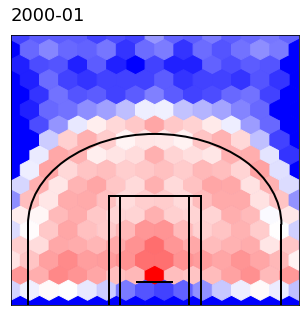

In [12]:
for season in seasons: 
#     url_base = 'https://stats.nba.com/stats/shotchartdetail'

#     headers = {
#             'Host': 'stats.nba.com',
#             'Connection': 'keep-alive',
#             'Accept': 'application/json, text/plain, */*',
#             'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
#             'Referer': 'https://stats.nba.com/',
#             "x-nba-stats-origin": "stats",
#             "x-nba-stats-token": "true",
#             'Accept-Encoding': 'gzip, deflate, br',
#             'Accept-Language': 'en-US,en;q=0.9',
#         }

#     parameters = {
#         'ContextMeasure': 'FGA',
#         'LastNGames': 0,
#         'LeagueID': '00',
#         'Month': 0,
#         'OpponentTeamID': 0,
#         'Period': 0,
#         'PlayerID': 0,
#         'SeasonType': 'Regular Season',
#         'TeamID': 0,
#         'VsDivision': '',
#         'VsConference': '',
#         'SeasonSegment': '',
#         'Season': season,
#         'RookieYear': '',
#         'PlayerPosition': '',
#         'Outcome': '',
#         'Location': '',
#         'GameSegment': '',
#         'GameId': '',
#         'DateTo': '',
#         'DateFrom': ''
#     }


#     response = requests.get(url_base, params=parameters, headers=headers)
#     content = json.loads(response.content)
    time.sleep(60)
    shot_json = shotchartdetail.ShotChartDetail(
            team_id = 0,
            player_id = 0,
            context_measure_simple = 'FGA',
            season_nullable = season,
            season_type_all_star = 'Regular Season')
    content = json.loads(shot_json.get_json())
    print("loaded",season)
    #transform contents into dataframe
    results = content['resultSets'][0]
    headers = results['headers']
    rows = results['rowSet']
    df = pd.DataFrame(rows)
   
    df.columns = headers
    fig = plt.figure(figsize=(4, 3.76))
    ax_initial = fig.add_axes([0, 0, 1, 1])
    ax = create_court(ax_initial, 'black')

    #Plot hexbin of shots
    ax.hexbin(df['LOC_X'], df['LOC_Y'] + 60, gridsize=(30, 30), extent=(-500, 500, 0, 1880*5/6), cmap='bwr')
    # Plot hexbin of shots with logarithmic binning
    ax.hexbin(df['LOC_X'], df['LOC_Y'] + 60, gridsize=(30, 30), extent=(-500, 500, 0, 1880*5/6), bins='log', cmap='bwr')# 
    # Annotate player name and season
    ax.text(0, 1.05, season, transform=ax.transAxes, ha='left', va='baseline')
    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor='black', lw=2))

    # write to csv file
    #df.to_csv(season + "_fga.csv", index=False)
